In [1]:
from dataclasses import dataclass
from typing import List, Dict, Tuple
import os, json, re, unicodedata, hashlib
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from statistics import mean
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- konfiguracja ---
EMBEDDING_MODEL_NAME = "intfloat/multilingual-e5-large-instruct"
EMB_CACHE_PATH = "intent_embeddings.npz"
SIM_THRESHOLD = 0.42
MAYBE_THRESHOLD = 0.32
DEFAULT_INTENTS_JSON = "intents.json"
TESTSET_JSON = "testset.json" # Plik z danymi testowymi

# Symulacja modelu embedding: Wymagane sentence-transformers (w realnym środowisku)
_model = None

def get_model():
    """Ładuje model embeddingów SentenceTransformer lub zwraca jego mock (poprawiona składnia global)."""
    global _model # Deklaracja na początku funkcji
    if _model is None:
        from sentence_transformers import SentenceTransformer
        _model = SentenceTransformer(EMBEDDING_MODEL_NAME)

    return _model

# Funkcje przetwarzania tekstu i haszowania
def normalize_text(t: str) -> str:
    t = t.lower().strip()
    t = unicodedata.normalize("NFKD", t)
    t = re.sub(r"[^a-ząćęłńóśźż0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t

def e5_encode(texts: List[str]) -> np.ndarray:
    model = get_model()
    return model.encode(texts, normalize_embeddings=True)

def embed_queries(texts: List[str]) -> np.ndarray:
    return e5_encode([f"query: {normalize_text(t)}" for t in texts])

def embed_passages(texts: List[str]) -> np.ndarray:
    return e5_encode([f"passage: {normalize_text(t)}" for t in texts])

def _file_sha1(path: str) -> str:
    """Oblicza SHA1 pliku. Jeśli plik nie istnieje, zwraca hasz nazwy."""
    h = hashlib.sha1()
    try:
        with open(path, "rb") as f:
            for chunk in iter(lambda: f.read(8192), b""):
                h.update(chunk)
        return h.hexdigest()
    except:
        return hashlib.sha1(path.encode()).hexdigest()

# Funkcje ładowania danych
def load_intents_from_json(path: str) -> Dict[str, Dict[str, List[str]]]:
    """Wczytuje intencje z pliku intents.json."""
    if not os.path.exists(path):
        # Symulowana zawartość w przypadku braku pliku (na podstawie Twojego kodu)
        print(f"Brak pliku {path}. Ładowanie z symulowanej zawartości (może się różnić od intencji treningowych).")
        intents_content = {
            "api/konie": {"examples": ["Proszę dodaj mi nowego konia Tajfuna"], "keywords": ["koń", "dodaj konia"]},
            "api/wydarzenia/zdarzenia_profilaktyczne": {"examples": ["Proszę dodać wpis, że moje konie miały odrobaczanie"], "keywords": ["profilaktyka", "szczepienie"]},
            "api/wydarzenia/rozrody": {"examples": ["Dino miał dzisiaj sprawdzanie źrebności."], "keywords": ["rozród", "ciąża"]},
            "api/wydarzenia/podkucie": {"examples": ["Dzisiaj Michał podkół mi wszystkie konie"], "keywords": ["podkucie", "kopyta"]},
            "api/wydarzenia/leczenia": {"examples": ["Dodaj leczenie kulawizny"], "keywords": ["leczenie", "terapia"]},
            "api/wydarzenia/choroby": {"examples": ["Ringo dzisiaj złamał nogę."], "keywords": ["choroba", "kolka"]},
            "api/kowale": {"examples": ["Dodaj mi kowala Jana Smarowskiego"], "keywords": ["kowal", "kowale"]},
            "api/weterynarze": {"examples": ["Dodaj mi weterynarza Jana Smarowskiego"], "keywords": ["weterynarz", "weterynarze"]}
        }
    else:
        with open(path, "r", encoding="utf-8") as f:
            intents_content = json.load(f)
            
    cleaned = {}
    for ep, spec in intents_content.items():
        if isinstance(spec, dict):
            exs = [x for x in spec.get("examples", []) if isinstance(x, str)]
            kws = [x for x in spec.get("keywords", []) if isinstance(x, str)]
            if exs:
                cleaned[ep] = {"examples": exs, "keywords": kws}
    if not cleaned:
        raise ValueError("Brak poprawnych intencji w pliku.")
    return cleaned


def load_testset_from_json(path: str):
    """Wczytuje testset z pliku testset.json."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Nie znaleziono pliku testowego: {path}. Sprawdź ścieżkę.")
        
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, dict):
        raise ValueError("Plik testset JSON musi być słownikiem endpoint -> [lista tekstów].")
    testset_data = {norm_ep(ep): samples for ep, samples in data.items() if isinstance(samples, list) and all(isinstance(x, str) for x in samples)}

    if not testset_data:
        raise ValueError("Zbiór testowy jest pusty.")
    
    total_test_samples = sum(len(samples) for samples in testset_data.values())
    print(f"Załadowano testset z {total_test_samples} frazami.")
    return testset_data

def norm_ep(ep: str) -> str:
    """Ujednolica endpointy (usuwa początkowe /)."""
    ep = (ep or "").strip()
    if ep.startswith("/"):
        ep = ep[1:]
    return ep

In [16]:
@dataclass
class IntentIndex:
    # Wersja Centroid: embeddings = Centroidy intencji
    # Wersja k-NN: embeddings = Wszystkie przykłady
    endpoints: List[str] # Lista endpointów (unikalnych dla centroid, powtarzających się dla k-NN)
    embeddings: np.ndarray 
    texts: List[str] # Przykładowy tekst (Centroid) lub oryginalne frazy (k-NN)
    intents_hash: str
    is_knn_index: bool = False # Nowy parametr

# ----------------------------------------------------
# 2.1. Centroid (Wersja pierwotna)
# ----------------------------------------------------

def build_intent_index_centroid(intents: Dict[str, Dict[str, List[str]]], intents_hash: str) -> IntentIndex:
    """Tworzy indeks semantyczny poprzez uśrednianie embeddingów przykładów dla każdej intencji (Centroid)."""
    endpoints, endpoint_embs, texts = [], [], []
    for ep, spec in intents.items():
        exs = spec["examples"]
        emb = embed_passages(exs)
        # Obliczenie uśrednionego embeddingu dla intencji
        avg = np.mean(emb, axis=0) 
        endpoints.append(ep)
        endpoint_embs.append(avg)
        texts.append("; ".join(exs[:3]))
    return IntentIndex(endpoints, np.stack(endpoint_embs, axis=0), texts, intents_hash, is_knn_index=False)

def predict_endpoint_centroid(
    user_text: str,
    idx: IntentIndex,
    intents: Dict[str, Dict[str, List[str]]],
    sim_threshold: float = None,
    maybe_threshold: float = None,
    top_k: int = 5
) -> Dict:
    """Główna funkcja klasyfikatora (Centroid), łącząca semantykę i fallback."""
    q_emb = embed_queries([user_text])
    sims = cosine_similarity(q_emb, idx.embeddings)[0]

    # Obliczenie progów dynamicznych
    mean_s, std_s = float(np.mean(sims)), float(np.std(sims))
    if sim_threshold is None:
        sim_threshold = max(SIM_THRESHOLD, mean_s - 0.3 * std_s)
    if maybe_threshold is None:
        maybe_threshold = max(MAYBE_THRESHOLD, mean_s - 0.6 * std_s)

    # Reranking Top-K (użycie średniego score z top 5 najbliższych intencji)
    top_indices = np.argsort(sims)[-top_k:]
    ep_scores = {}
    for i in top_indices:
        ep = idx.endpoints[i]
        ep_scores.setdefault(ep, []).append(sims[i])
    
    best_ep = max(ep_scores, key=lambda e: np.mean(ep_scores[e]), default="")
    best_score = float(np.mean(ep_scores[best_ep])) if best_ep else 0.0

    # Logika klasyfikacji: Semantic > Semantic_Low (+Fallback) > Fallback > Unknown
    if best_score >= sim_threshold:
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": "semantic"}

    if best_score >= maybe_threshold:
        ep_kw, reason = keyword_fallback(user_text, intents)
        if ep_kw:
            return {"endpoint": ep_kw, "score": round(best_score, 4), "method": "semantic+fallback", "debug": reason}
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": "semantic_low"}

    ep_kw, reason = keyword_fallback(user_text, intents)
    if ep_kw:
        return {"endpoint": ep_kw, "score": round(best_score, 4), "method": "fallback", "debug": reason}

    return {"endpoint": "", "score": round(best_score, 4), "method": "unknown"}


# ----------------------------------------------------
# 2.2. k-NN (Nowa wersja)
# ----------------------------------------------------

def build_intent_index_knn(intents: Dict[str, Dict[str, List[str]]], intents_hash: str) -> IntentIndex:
    """Tworzy indeks k-NN, przechowując embeddingi wszystkich przykładów treningowych."""
    endpoints_all, embeddings_all, texts_all = [], [], []
    for ep, spec in intents.items():
        exs = spec["examples"]
        emb = embed_passages(exs)
        
        embeddings_all.append(emb)
        endpoints_all.extend([ep] * len(exs))
        texts_all.extend(exs)

    embeddings_combined = np.concatenate(embeddings_all, axis=0) if embeddings_all else np.array([])

    return IntentIndex(endpoints_all, embeddings_combined, texts_all, intents_hash, is_knn_index=True)


def predict_endpoint_knn(
    user_text: str,
    idx: IntentIndex,
    intents: Dict[str, Dict[str, List[str]]],
    k: int = 5, # Parametr K
    sim_threshold: float = None,
    maybe_threshold: float = None,
) -> Dict:
    """Funkcja klasyfikatora oparta na k-NN (większościowe głosowanie K najbliższych sąsiadów)."""
    if not idx.embeddings.size:
        return {"endpoint": "", "score": 0.0, "method": "unknown", "debug": "Pusty indeks k-NN"}

    q_emb = embed_queries([user_text])
    sims = cosine_similarity(q_emb, idx.embeddings)[0]
    
    # Znajdowanie K najbliższych sąsiadów (k+1, bo k=5 to 5 najbliższych, k=1 to 1)
    # Wybieramy 'k' największych wartości podobieństwa
    top_k_indices = np.argsort(sims)[-k:][::-1]
    
    top_k_endpoints = [idx.endpoints[i] for i in top_k_indices]
    top_k_scores = [sims[i] for i in top_k_indices]
    
    # Głosowanie: Wybór najczęściej występującego endpointa
    from collections import Counter
    vote_counts = Counter(top_k_endpoints)
    best_ep = vote_counts.most_common(1)[0][0] if vote_counts else ""
    
    # Wynik (score): Używamy średniej podobieństwa dla K najbliższych sąsiadów
    best_score = float(np.mean(top_k_scores)) if top_k_scores else 0.0

    # Obliczenie progów dynamicznych
    mean_s, std_s = float(np.mean(sims)), float(np.std(sims))
    if sim_threshold is None:
        sim_threshold = max(SIM_THRESHOLD, mean_s - 0.3 * std_s)
    if maybe_threshold is None:
        maybe_threshold = max(MAYBE_THRESHOLD, mean_s - 0.6 * std_s)

    # Logika klasyfikacji
    if best_score >= sim_threshold:
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": f"knn_semantic (k={k})"}

    if best_score >= maybe_threshold:
        ep_kw, reason = keyword_fallback(user_text, intents)
        if ep_kw:
            return {"endpoint": ep_kw, "score": round(best_score, 4), "method": f"knn_semantic+fallback (k={k})", "debug": reason}
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": f"knn_semantic_low (k={k})"}

    ep_kw, reason = keyword_fallback(user_text, intents)
    if ep_kw:
        return {"endpoint": ep_kw, "score": round(best_score, 4), "method": "fallback", "debug": reason}

    return {"endpoint": "", "score": round(best_score, 4), "method": "unknown"}

# Funkcja Fallback pozostaje ta sama
def keyword_fallback(text: str, intents: Dict[str, Dict[str, List[str]]]) -> Tuple[str, str]:
    """Prosty, stabilny fallback oparty o liczbę słów-kluczy."""
    t = normalize_text(text)
    best_ep, best_hits = "", 0
    for ep, spec in intents.items():
        hits = sum(1 for kw in spec.get("keywords", []) if normalize_text(kw) in t)
        if hits > best_hits:
            best_ep, best_hits = ep, hits
    return (best_ep, f"{best_hits} keyword hits") if best_hits else ("", "")

# Funkcja budowania/ładowania indeksu musi obsługiwać oba typy
def build_or_load_index(intents: Dict[str, Dict[str, List[str]]], intents_hash: str, model_type: str, force_rebuild: bool = False) -> IntentIndex:
    """Ładuje indeks z cache lub go buduje dla wybranego modelu."""
    # Tworzenie unikalnej ścieżki cache dla każdego typu modelu
    cache_path = EMB_CACHE_PATH.replace(".npz", f"_{model_type}.npz")
    
    if (not force_rebuild) and os.path.exists(cache_path):
        try:
            idx = load_index(cache_path)
            if idx.intents_hash == intents_hash:
                print(f"Załadowano indeks '{model_type}' z pamięci podręcznej (cache).")
                return idx
        except Exception:
            pass 
    
    print(f"Budowanie indeksu semantycznego ({model_type})...")
    if model_type == 'centroid':
        idx = build_intent_index_centroid(intents, intents_hash)
    elif model_type == 'knn':
        idx = build_intent_index_knn(intents, intents_hash)
    else:
        raise ValueError(f"Nieznany typ modelu: {model_type}")
        
    save_index(idx, cache_path)
    print("Indeks zbudowany i zapisany.")
    return idx

# Logika Predykcji
def keyword_fallback(text: str, intents: Dict[str, Dict[str, List[str]]]) -> Tuple[str, str]:
    """Prosty, stabilny fallback oparty o liczbę słów-kluczy."""
    t = normalize_text(text)
    best_ep, best_hits = "", 0
    for ep, spec in intents.items():
        hits = sum(1 for kw in spec.get("keywords", []) if normalize_text(kw) in t)
        if hits > best_hits:
            best_ep, best_hits = ep, hits
    return (best_ep, f"{best_hits} keyword hits") if best_hits else ("", "")

def predict_endpoint(
    user_text: str,
    idx: IntentIndex,
    intents: Dict[str, Dict[str, List[str]]],
    sim_threshold: float = None,
    maybe_threshold: float = None,
    top_k: int = 5
) -> Dict:
    """Główna funkcja klasyfikatora, łącząca semantykę i fallback."""
    q_emb = embed_queries([user_text])
    sims = cosine_similarity(q_emb, idx.embeddings)[0]

    # Obliczenie progów dynamicznych (adaptacyjne progi)
    mean_s, std_s = float(np.mean(sims)), float(np.std(sims))
    if sim_threshold is None:
        sim_threshold = max(SIM_THRESHOLD, mean_s - 0.3 * std_s)
    if maybe_threshold is None:
        maybe_threshold = max(MAYBE_THRESHOLD, mean_s - 0.6 * std_s)

    # Reranking Top-K dla stabilniejszego wyboru
    top_indices = np.argsort(sims)[-top_k:]
    ep_scores = {}
    for i in top_indices:
        ep = idx.endpoints[i]
        ep_scores.setdefault(ep, []).append(sims[i])
    
    best_ep = max(ep_scores, key=lambda e: np.mean(ep_scores[e]), default="")
    best_score = float(np.mean(ep_scores[best_ep])) if best_ep else 0.0

    # Logika klasyfikacji: Semantic > Semantic_Low (+Fallback) > Fallback > Unknown
    if best_score >= sim_threshold:
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": "semantic"}

    if best_score >= maybe_threshold:
        ep_kw, reason = keyword_fallback(user_text, intents)
        if ep_kw:
            return {"endpoint": ep_kw, "score": round(best_score, 4), "method": "semantic+fallback", "debug": reason}
        return {"endpoint": best_ep, "score": round(best_score, 4), "method": "semantic_low"}

    ep_kw, reason = keyword_fallback(user_text, intents)
    if ep_kw:
        return {"endpoint": ep_kw, "score": round(best_score, 4), "method": "fallback", "debug": reason}

    return {"endpoint": "", "score": round(best_score, 4), "method": "unknown"}

In [19]:
def evaluate_classifier(intents: Dict, testset: Dict, intents_hash: str, model_type: str = 'centroid', knn_k: int = 5, force_rebuild: bool = False):
    """
    Uruchamia predykcję na całym zbiorze testowym, oblicza metryki i zwraca wyniki dla danego typu modelu.
    """
    idx = build_or_load_index(intents=intents, intents_hash=intents_hash, model_type=model_type, force_rebuild=force_rebuild)
    
    y_true, y_pred, samples_debug = [], [], []
    labels_for_report = sorted(set(list(testset.keys()) + list(intents.keys())))

    # Wybór funkcji predykcyjnej
    if model_type == 'centroid':
        predict_func = predict_endpoint_centroid
        method_name = "Centroid"
    elif model_type == 'knn':
        predict_func = lambda txt, i, ins: predict_endpoint_knn(txt, i, ins, k=knn_k)
        method_name = f"k-NN (k={knn_k})"
    else:
        raise ValueError("Nieznany typ modelu do ewaluacji.")

    # Główna pętla predykcyjna na testsecie
    for true_ep, texts in testset.items():
        for txt in texts:
            out = predict_func(txt, idx, intents)
            pred_ep = norm_ep(out.get("endpoint", ""))

            y_true.append(true_ep)
            y_pred.append(pred_ep)
            samples_debug.append({
                "text": txt,
                "true": true_ep,
                "pred": pred_ep,
                "method": out.get("method"),
                "score": out.get("score"),
                "debug": out.get("debug"),
            })

    # Obliczanie metryk (kod pozostaje taki sam)
    acc = accuracy_score(y_true, y_pred)
    pr_micro, rc_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_for_report, average="micro", zero_division=0
    )
    pr_macro, rc_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_for_report, average="macro", zero_division=0
    )

    print(f"\n--- WYNIKI OGÓLNE ({method_name}) ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (micro): {pr_micro:.4f} | Recall (micro): {rc_micro:.4f} | F1 (micro): {f1_micro:.4f}")
    print(f"Precision (macro): {pr_macro:.4f} | Recall (macro): {rc_macro:.4f} | F1 (macro): {f1_macro:.4f}")
    print()

    # Reszta funkcji jest taka sama, zwróci słownik wyników.
    cm = confusion_matrix(y_true, y_pred, labels=labels_for_report)
    errors = [s for s in samples_debug if s["true"] != s["pred"]]
    correct = [s for s in samples_debug if s["true"] == s["pred"]]
    
    return {
        "acc": acc,
        "f1_macro": f1_macro,
        "cm": cm,
        "labels": labels_for_report,
        "errors": errors,
        "correct": correct,
    }

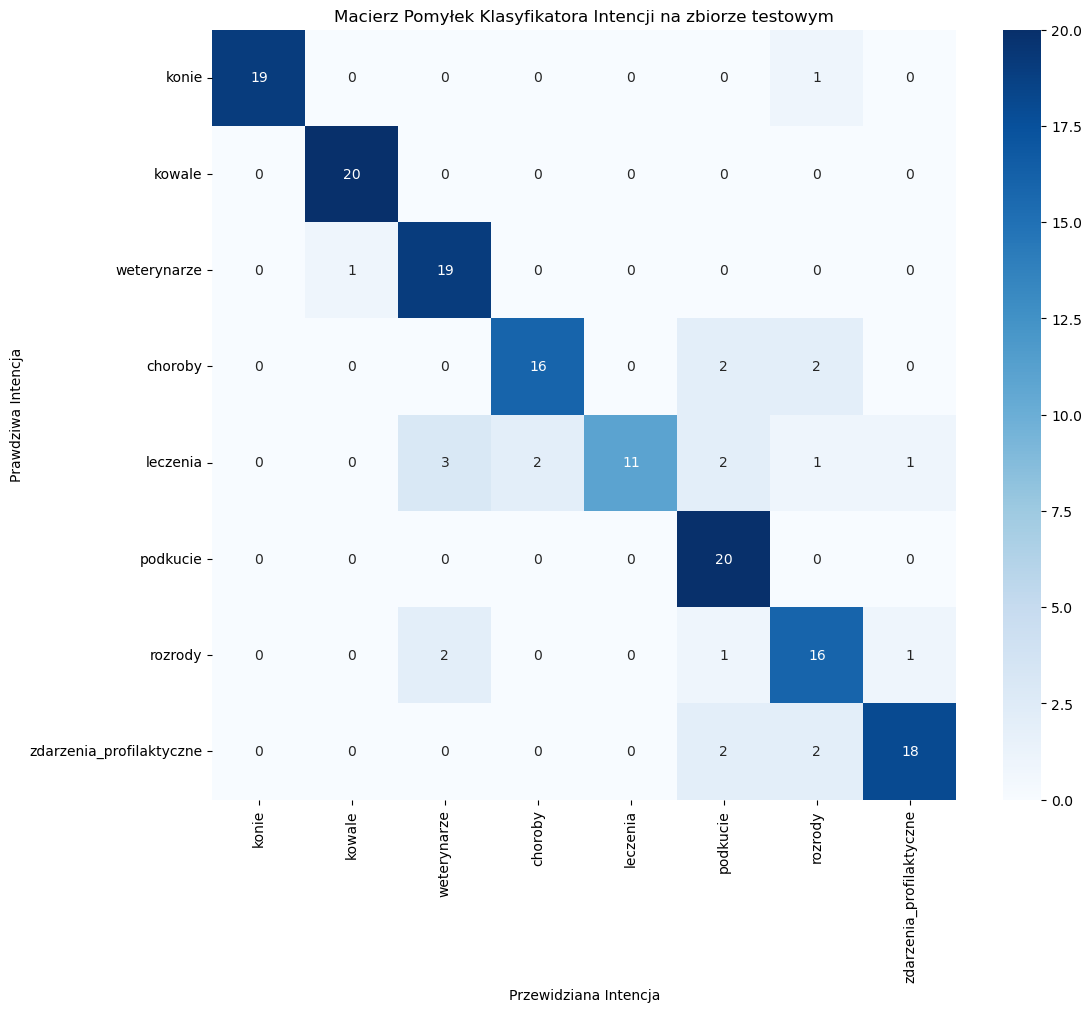

In [18]:
# Wizualizacja Macierzy Pomyłek
plt.figure(figsize=(12, 10))

# Użycie tylko ostatniej części endpointa dla lepszej czytelności etykiet
display_labels = [l.split('/')[-1] for l in labels]

sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=display_labels, 
    yticklabels=display_labels,
    cbar=True
)
plt.title('Macierz Pomyłek Klasyfikatora Intencji na zbiorze testowym')
plt.ylabel('Prawdziwa Intencja')
plt.xlabel('Przewidziana Intencja')
plt.show()



In [20]:
errors = results["errors"]
correct = results["correct"]

if errors:
    print("\n=== STATYSTYKI SCORE ===")
    mean_correct = mean([s["score"] for s in correct if s["score"] is not None]) if correct else 0
    mean_wrong = mean([s["score"] for s in errors if s["score"] is not None]) if errors else 0
    print(f"Średni score poprawnych predykcji: {mean_correct:.4f}")
    print(f"Średni score błędnych predykcji:   {mean_wrong:.4f}")
    print(f"Łączna liczba błędnych predykcji: {len(errors)} / {total_test_samples}")
    print()

    print(f"=== PRZYKŁADOWE BŁĘDY (TOP-10 NAJNIŻSZYCH SCORE) ===")
    # Sortowanie błędów według najniższego score (najmniej pewne predykcje)
    errors.sort(key=lambda x: (x.get("score") if x.get("score") is not None else -1))
    for e in errors[:10]:
        print(f"- text: {e['text']}\n  true: {e['true']}\n  pred: {e['pred']} (method={e['method']}, score={e['score']}, debug={e.get('debug', 'N/A')})\n")
else:
    print("\nBrak błędnych predykcji ")


=== STATYSTYKI SCORE ===
Średni score poprawnych predykcji: 0.9291
Średni score błędnych predykcji:   0.9150
Łączna liczba błędnych predykcji: 23 / 162

=== PRZYKŁADOWE BŁĘDY (TOP-10 NAJNIŻSZYCH SCORE) ===
- text: Trzeba odrobaczyć Furię, wpisz to na za tydzień, zajmie się tym Tomasz Żuk.
  true: api/wydarzenia/zdarzenia_profilaktyczne
  pred: api/wydarzenia/podkucie (method=semantic, score=0.897, debug=None)

- text: Ringo wczoraj na treningu naciągnął sobie mięsień grzbietu.
  true: api/wydarzenia/choroby
  pred: api/wydarzenia/podkucie (method=semantic, score=0.8972, debug=None)

- text: Maks przyszedł i podał czarnej maść na ból stawów
  true: api/wydarzenia/leczenia
  pred: api/wydarzenia/podkucie (method=semantic, score=0.8976, debug=None)

- text: Dziś w nocy oźrebiła się Niwka! Poród odbierała Zofia Bukowska, wszystko w porządku.
  true: api/wydarzenia/rozrody
  pred: api/wydarzenia/podkucie (method=semantic, score=0.9032, debug=None)

- text: Bruno podał leki na pruchnice kró

In [21]:
# Ustawienie parametru K dla różnych scenariuszy
TEST_K_VALUES = [3, 5, 7]

print("=========================================")
print("  EWALUACJA KLASYFIKATORA: CENTROID vs k-NN")
print("=========================================")

# 1. Definicja scenariuszy testowych
test_scenarios = [
    {'type': 'centroid', 'k': 0, 'label': 'Centroid'},
]
for k in TEST_K_VALUES:
    test_scenarios.append({'type': 'knn', 'k': k, 'label': f'k-NN (k={k})'})

all_results = []

# 2. Wykonanie ewaluacji dla każdego scenariusza
for scenario in test_scenarios:
    model_type = scenario['type']
    knn_k = scenario['k']
    
    # Wymuszamy przebudowanie indeksu, jeśli typ modelu się zmienia
    # W Centroid i pierwszym k-NN, budujemy nowy indeks.
    force_rebuild = (model_type == 'centroid') or (model_type == 'knn' and knn_k == TEST_K_VALUES[0])
    
    print(f"\n--- Rozpoczęcie testu: {scenario['label']} ---")
    
    results = evaluate_classifier(
        intents=intents, 
        testset=testset, 
        intents_hash=intents_hash, 
        model_type=model_type,
        knn_k=knn_k,
        force_rebuild=force_rebuild
    )
    
    # Dodanie etykiety scenariusza i wyników do listy
    results['method_label'] = scenario['label']
    all_results.append(results)

# 3. Wyświetlenie tabeli podsumowującej
print("\n=========================================")
print(" PODSUMOWANIE WYNIKÓW EWALUACJI")
print("=========================================")
print("| Metoda      | Accuracy | F1-Macro |")
print("|-------------|----------|----------|")
for r in all_results:
    print(f"| {r['method_label']:<11} | {r['acc']:.4f}   | {r['f1_macro']:.4f}   |")
print("|-------------|----------|----------|")

  EWALUACJA KLASYFIKATORA: CENTROID vs k-NN

--- Rozpoczęcie testu: Centroid ---
Budowanie indeksu semantycznego (centroid)...
Indeks zbudowany i zapisany.

--- WYNIKI OGÓLNE (Centroid) ---
Accuracy: 0.8580
Precision (micro): 0.8580 | Recall (micro): 0.8580 | F1 (micro): 0.8580
Precision (macro): 0.8751 | Recall (macro): 0.8585 | F1 (macro): 0.8544


--- Rozpoczęcie testu: k-NN (k=3) ---
Budowanie indeksu semantycznego (knn)...
Indeks zbudowany i zapisany.

--- WYNIKI OGÓLNE (k-NN (k=3)) ---
Accuracy: 0.8580
Precision (micro): 0.8580 | Recall (micro): 0.8580 | F1 (micro): 0.8580
Precision (macro): 0.8608 | Recall (macro): 0.8591 | F1 (macro): 0.8543


--- Rozpoczęcie testu: k-NN (k=5) ---
Załadowano indeks 'knn' z pamięci podręcznej (cache).

--- WYNIKI OGÓLNE (k-NN (k=5)) ---
Accuracy: 0.8765
Precision (micro): 0.8765 | Recall (micro): 0.8765 | F1 (micro): 0.8765
Precision (macro): 0.8836 | Recall (macro): 0.8756 | F1 (macro): 0.8717


--- Rozpoczęcie testu: k-NN (k=7) ---
Załadowano 

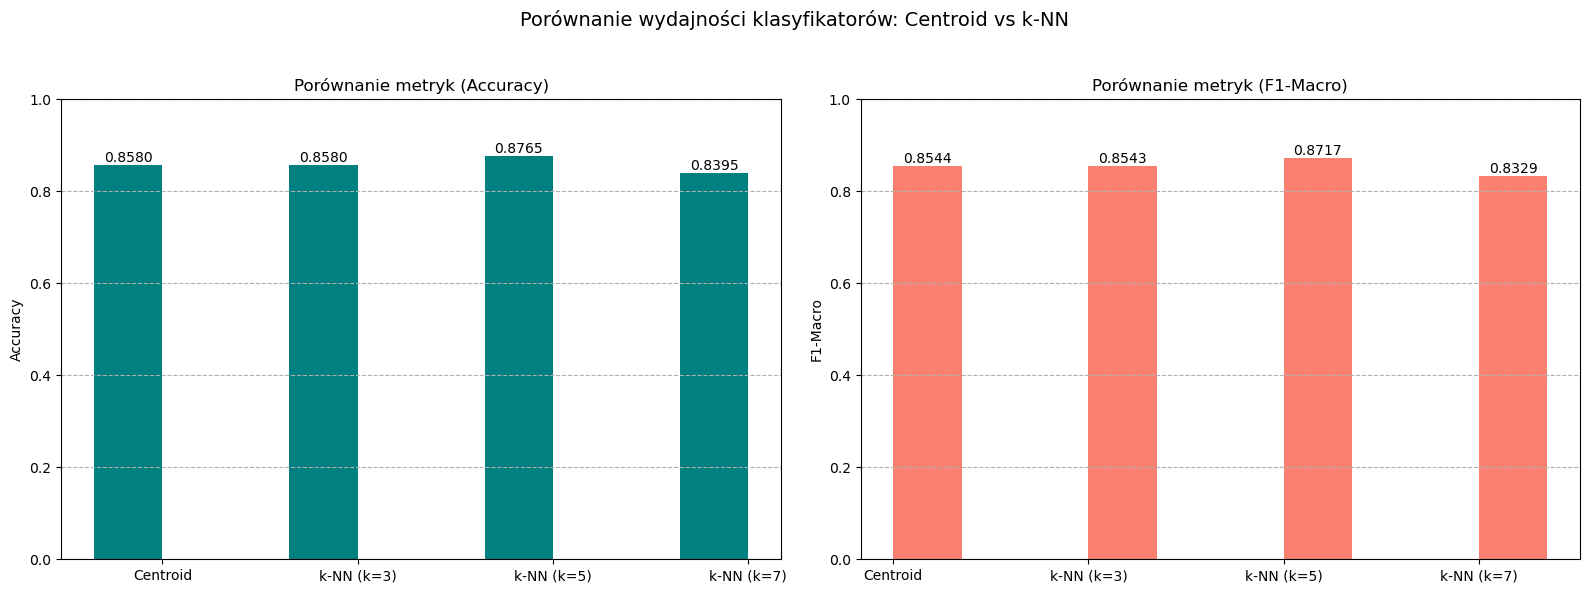


🖼️ WIZUALIZACJA: MACIERZ POMYŁEK DLA k-NN (k=5)


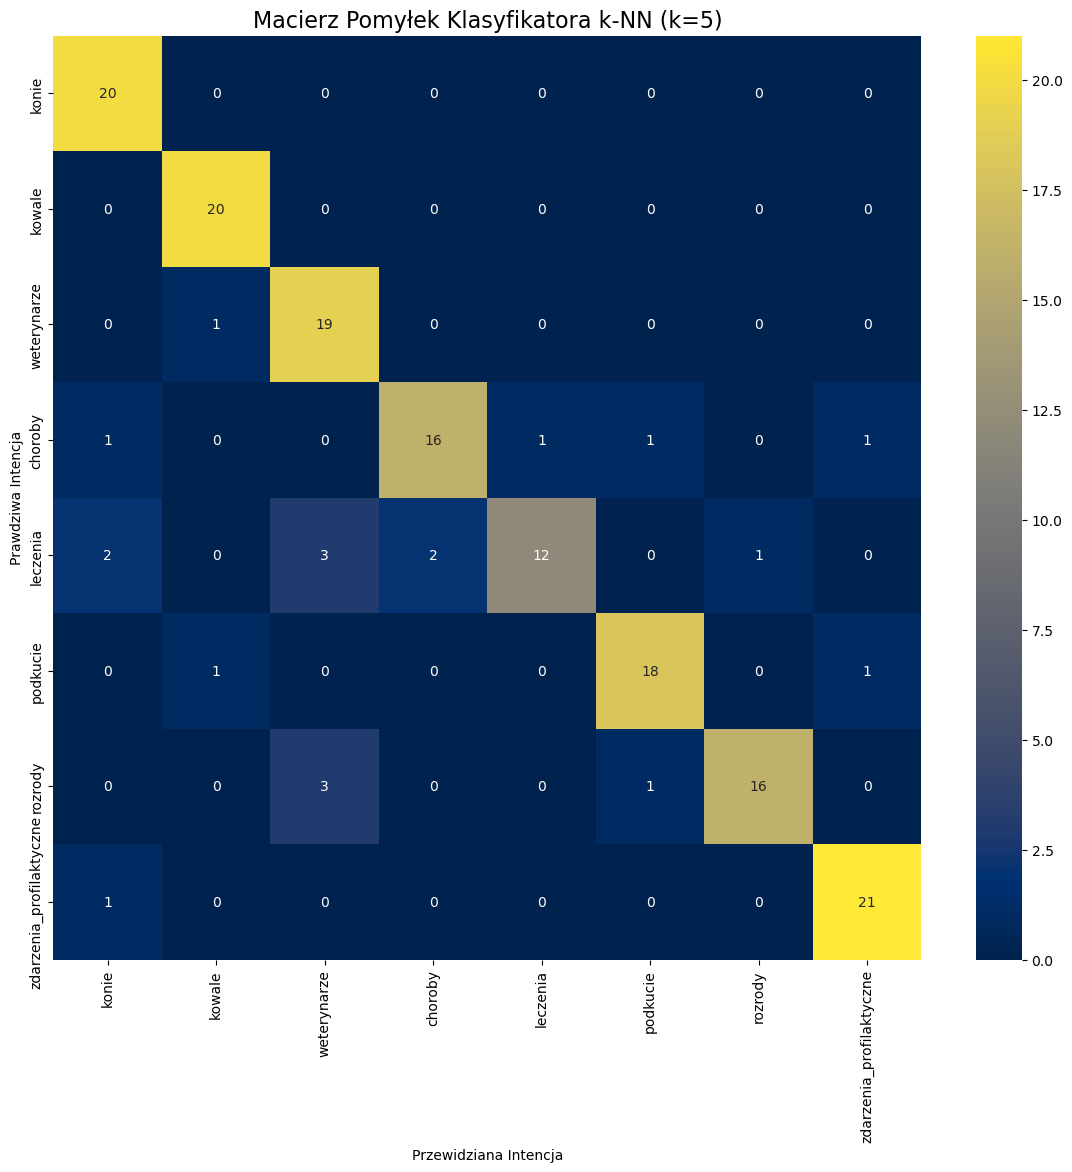

In [23]:
# Dane do wizualizacji (pobrane ze zmiennej all_results z poprzedniego bloku)
df_results = {
    'Metoda': [r['method_label'] for r in all_results],
    'Accuracy': [r['acc'] for r in all_results],
    'F1-Macro': [r['f1_macro'] for r in all_results],
}

# 1. Wizualizacja Porównawcza (Accuracy i F1-Macro)
plt.figure(figsize=(16, 6))
x = np.arange(len(df_results['Metoda']))
width = 0.35
labels = df_results['Metoda']

# --- Wykres Accuracy ---
plt.subplot(1, 2, 1)
rects1 = plt.bar(x - width/2, df_results['Accuracy'], width, label='Accuracy', color='teal')
plt.ylabel('Accuracy')
plt.title('Porównanie metryk (Accuracy)')
plt.xticks(x, labels)
plt.bar_label(rects1, fmt='%.4f')
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--')

# --- Wykres F1-Macro ---
plt.subplot(1, 2, 2)
rects2 = plt.bar(x + width/2, df_results['F1-Macro'], width, label='F1-Macro', color='salmon')
plt.ylabel('F1-Macro')
plt.title('Porównanie metryk (F1-Macro)')
plt.xticks(x, labels)
plt.bar_label(rects2, fmt='%.4f')
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--')

plt.suptitle('Porównanie wydajności klasyfikatorów: Centroid vs k-NN', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show() # Wyświetlenie wykresów

# 2. Wybór i Wizualizacja Macierzy Pomyłek (CM)
# Wybieramy Macierz Pomyłek dla k-NN (k=5) do szczegółowej analizy
CM_SCENARIO_INDEX = 2 # Indeks 2 odpowiada 'k-NN (k=5)' (0=Centroid, 1=k-NN k=3, 2=k-NN k=5)
selected_results = all_results[CM_SCENARIO_INDEX]

cm = selected_results["cm"]
labels_full = selected_results["labels"]
cm_method = selected_results["method_label"]
display_labels = [l.split('/')[-1] for l in labels_full] # Skrócone nazwy endpointów

print(f"\n=========================================")
print(f"🖼️ WIZUALIZACJA: MACIERZ POMYŁEK DLA {cm_method}")
print("=========================================")

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="cividis", # Ciemniejszy, kontrastowy schemat
    xticklabels=display_labels, 
    yticklabels=display_labels,
    cbar=True
)
plt.title(f'Macierz Pomyłek Klasyfikatora {cm_method}', fontsize=16)
plt.ylabel('Prawdziwa Intencja')
plt.xlabel('Przewidziana Intencja')
plt.show() # Wyświetlenie macierzy pomyłek

